<a href="https://colab.research.google.com/github/nacho-gonz/MdD-TUIA-2024/blob/master/TP3/TP3_MdD_TUIA_Noir_Gonzalez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Información.

Primer integrante: Noir Nicolás,  N-1273/4

Segundo integrante: González Ignacio,  G-5933/1

Materia: Minería de datos

Año: 2024



## Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import style
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## Carga de datasets

In [ ]:
df = pd.read_csv('https://raw.github.com/Nicolas-Noir/MdD-TUIA-2024/main/TP3/dxWeather.csv')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Estacion', axis=1), df['Estacion'], test_size=0.25, random_state=9345)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7567, 7), (2523, 7), (7567,), (2523,))

## Analisis descriptivo

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7567 entries, 5471 to 9328
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         7567 non-null   int64  
 1   Humedad             7567 non-null   int64  
 2   VientoVelocidad     7567 non-null   float64
 3   Precipitation       7567 non-null   int64  
 4   PresionAtmosferica  7567 non-null   float64
 5   Localizacion        7567 non-null   object 
 6   TipoClima           7567 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 472.9+ KB


El dataset no presenta valores faltantes, entonces no es necesario el proceso de imputación de valores faltantes.

In [ ]:
x_train.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,7567.000000,7567.000000,7567.000000,7567.000000,7567.000000
mean,22.002114,67.143914,9.640544,50.677019,1007.557701
std,16.300768,20.426351,6.782162,32.334461,39.087354
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,54.000000,5.000000,18.000000,998.660000
50%,24.000000,68.000000,8.500000,53.000000,1010.360000
75%,32.000000,81.000000,13.500000,80.000000,1017.855000
max,108.000000,109.000000,47.500000,109.000000,1199.210000


El dataset presenta variables con escalas diferentes, esto nos lleva a tener que escalar las variables para no tener posibles problemas en la creación de los diferentes modelos

## Análisis exploratorio

In [ ]:
train_completo = pd.merge(x_train, y_train, left_index=True, right_index=True)

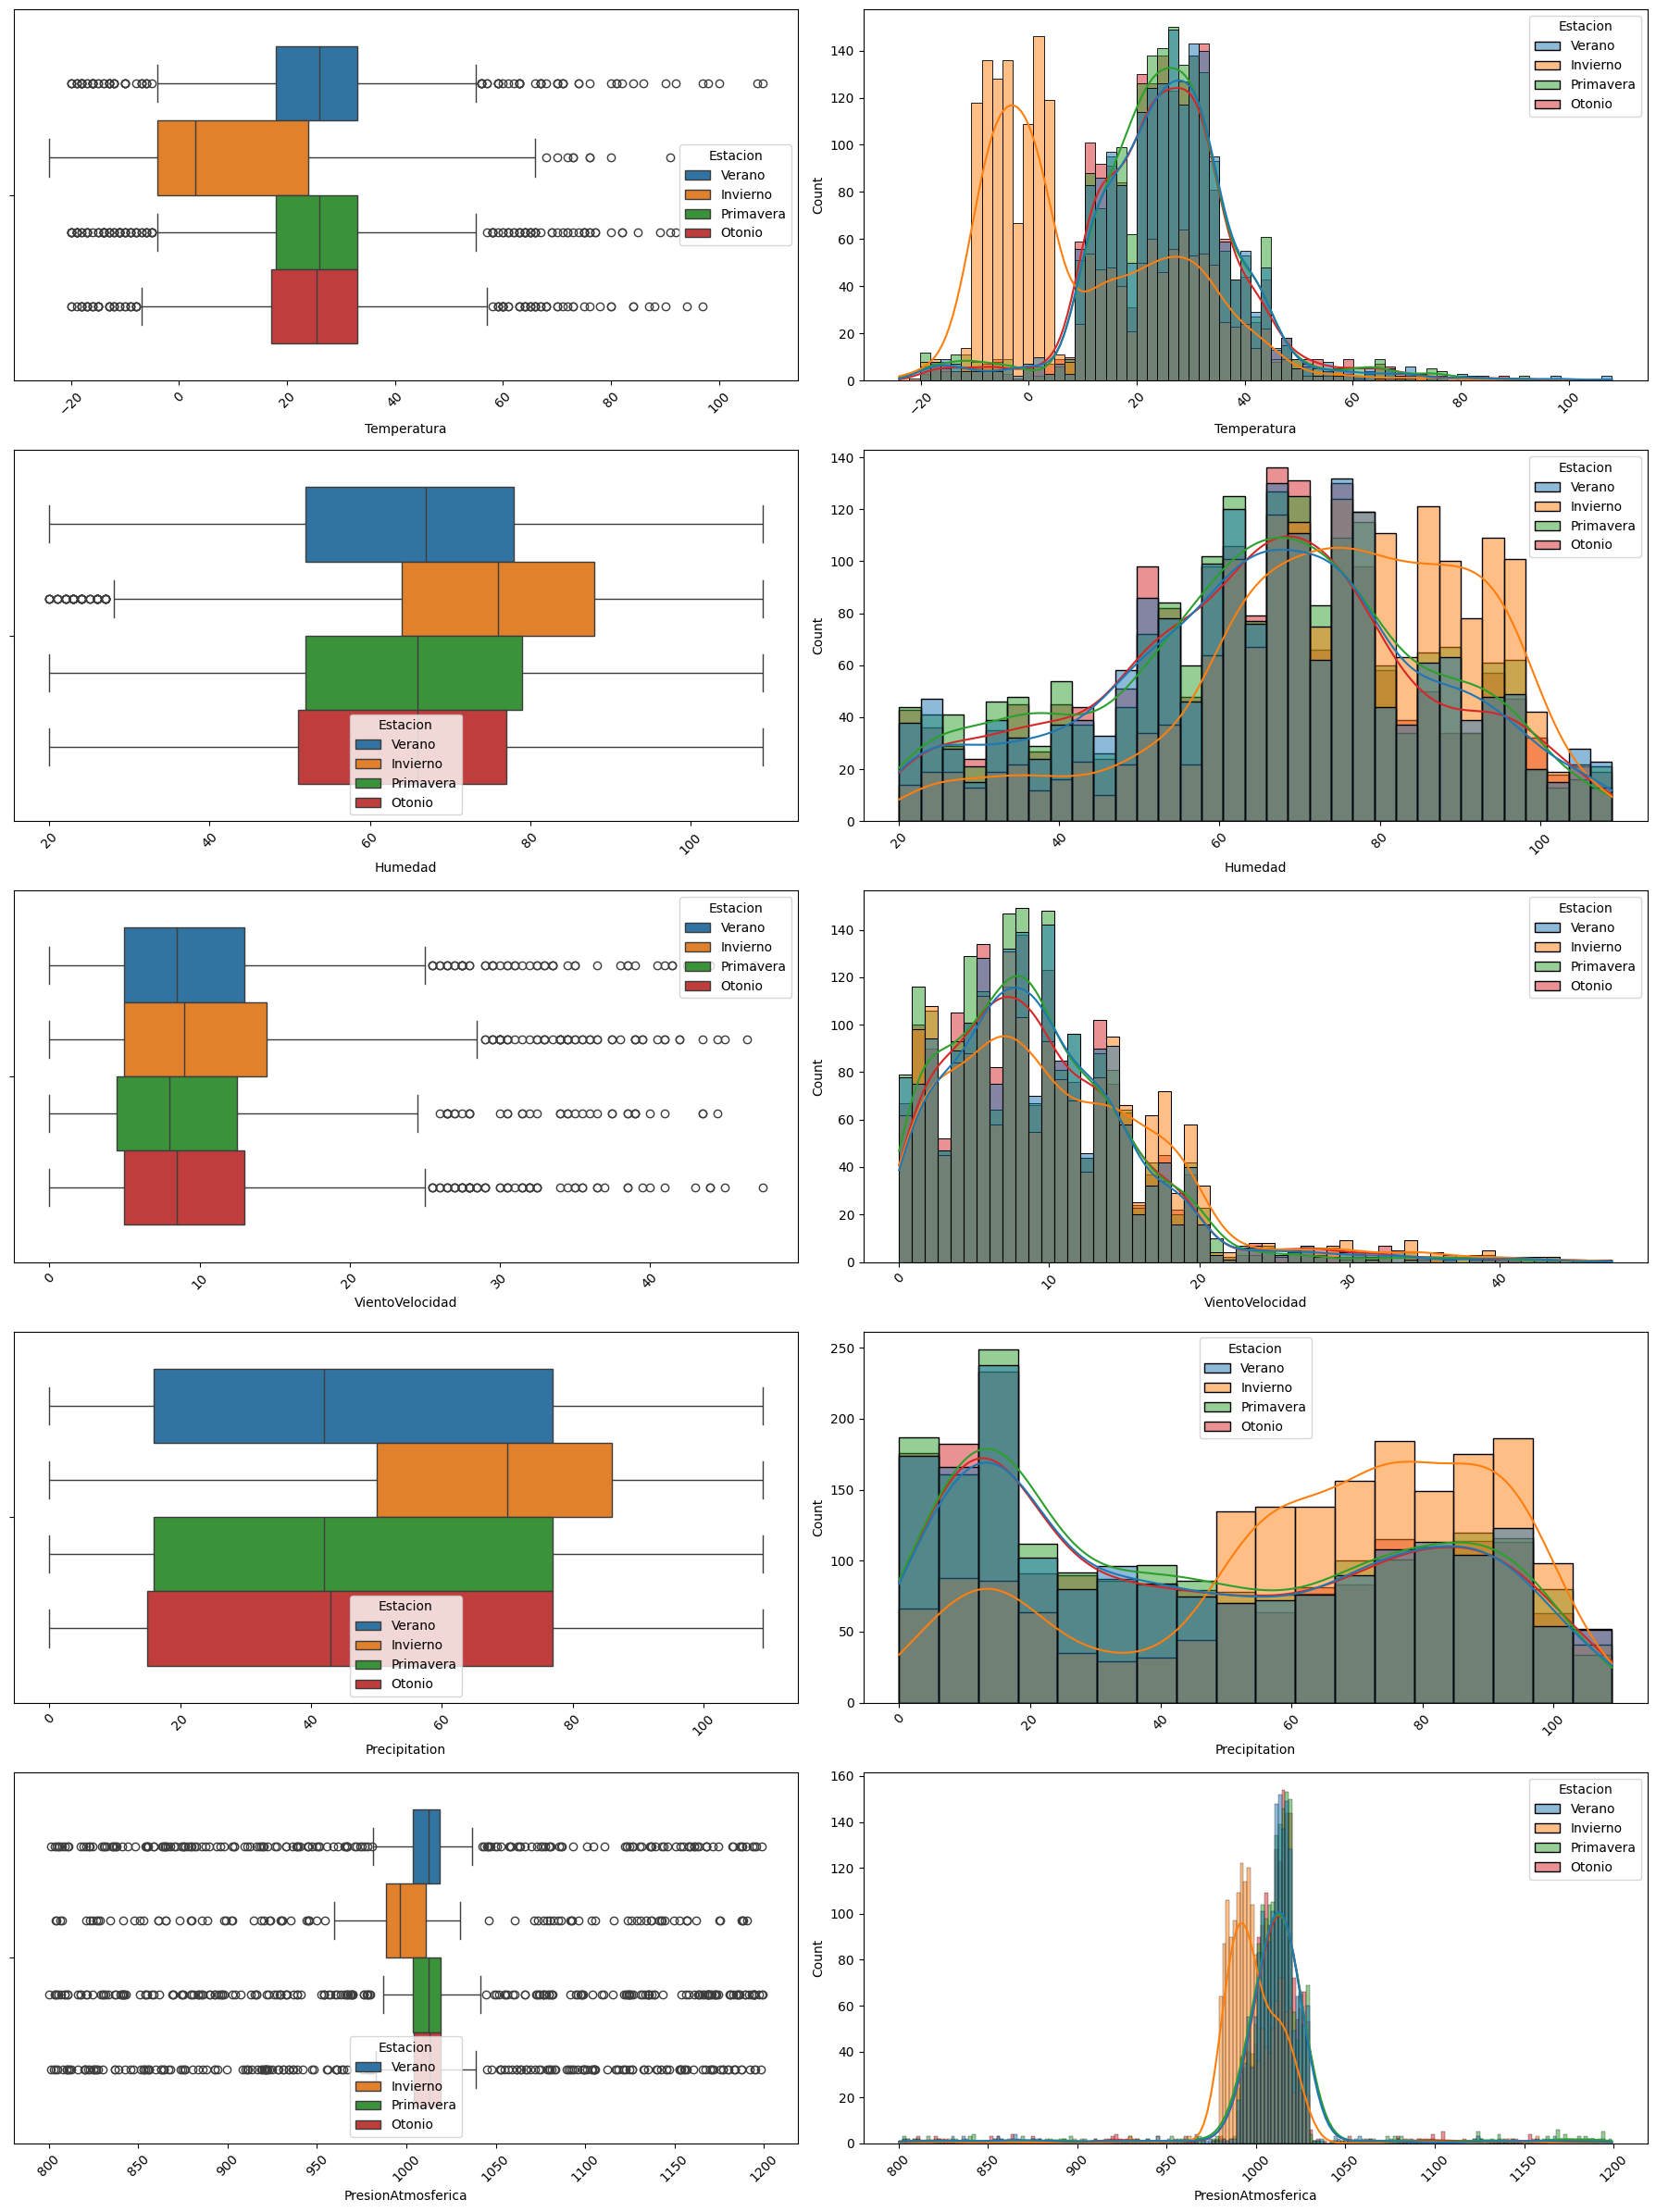

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(18, 24))

for i, name in enumerate(train_completo[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation','PresionAtmosferica']]):

   sns.boxplot(x=name, data=train_completo, orient='h', ax=axes[i, 0], hue='Estacion')
   axes[i, 0].tick_params(axis='x', rotation=45)

   sns.histplot(x=name, data=train_completo, ax=axes[i, 1], kde=True, hue='Estacion')
   axes[i, 1].tick_params(axis='x', rotation=45)


fig.tight_layout()
plt.show()

Se observa que no hay ninguna variable que pueda ser la más importante para la clasificación de la estación, ya que las distribuciones de las variables dependiendo la estación son casi iguales. La única Estación que pueda llegar a ser diferenciada por las variables numéricas es invierno, ya que en todas las variables tiene una mediana diferente, un RIQ más pequeño y su distribución esta notablemente separada.

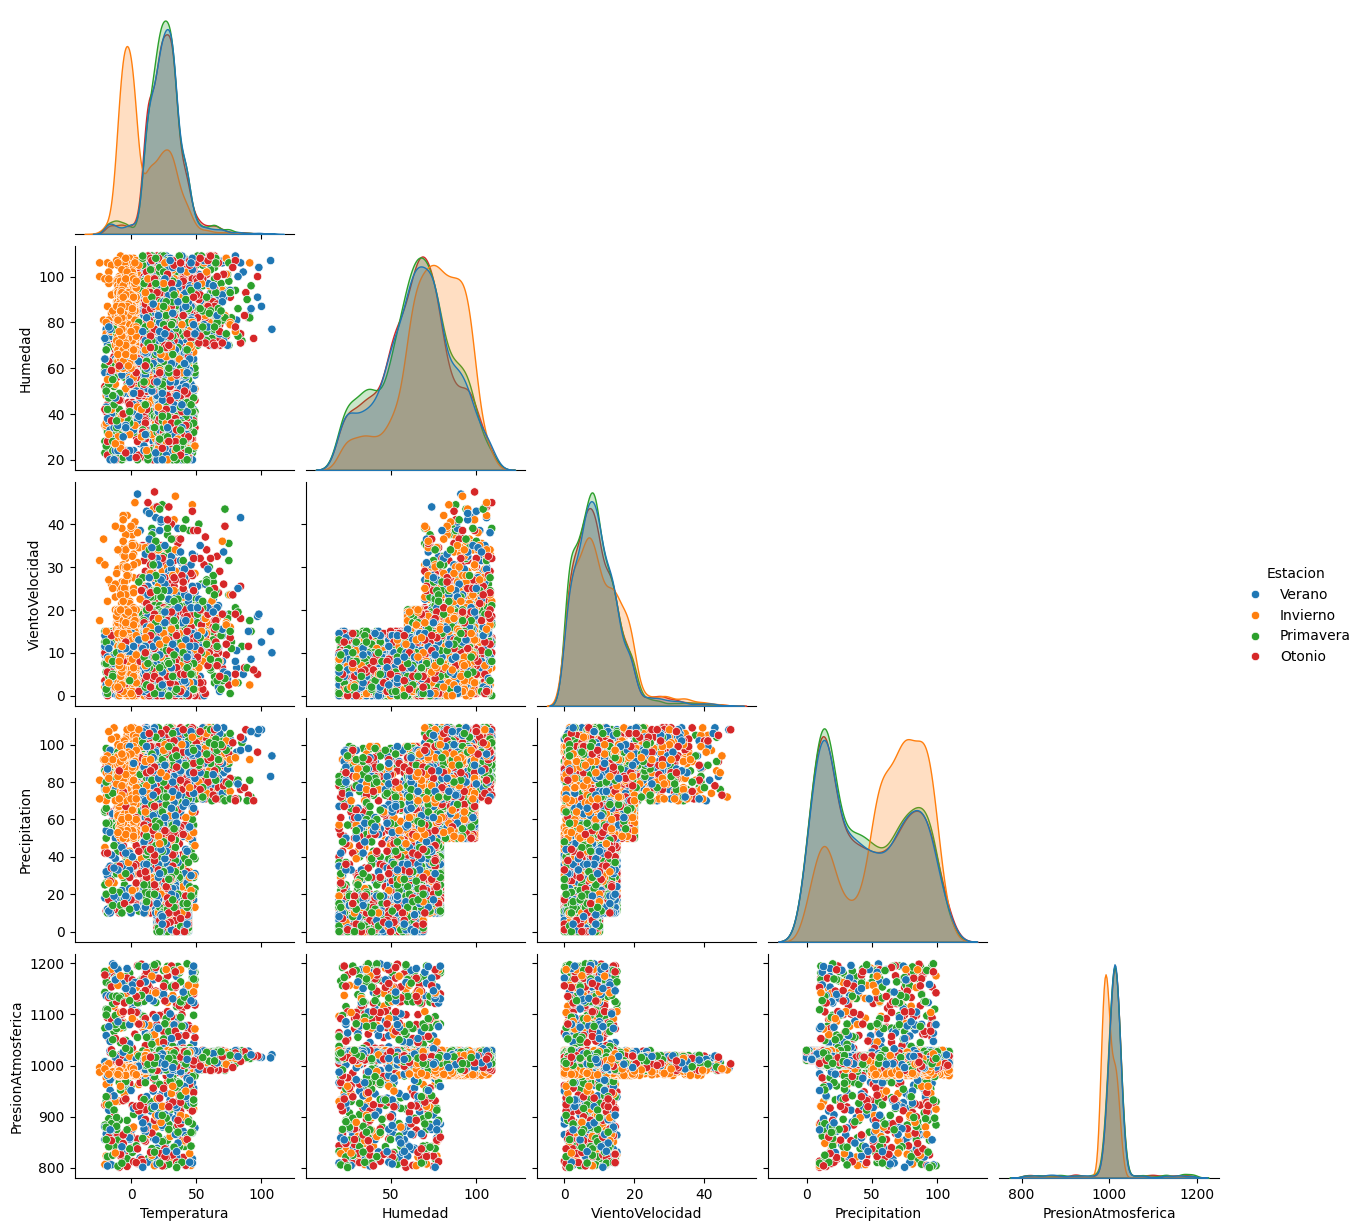

In [ ]:
 sns.pairplot(train_completo, hue='Estacion',x_vars=['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation','PresionAtmosferica'],y_vars=['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation','PresionAtmosferica'], corner=True)
 plt.show()

Según lo observado, no podemos identificar alguna relación que nos permita clasificar las clases de manera sencilla. Aun así, si observamos la columna de temperatura y la comparamos con velocidad del viento, precipitación y humedad, llegamos a diferenciar el invierno. No se observa alguna relación lineal entre las variables. Pero si se observan relaciones raras como la fila de presión atmosférica, donde en las variables temperatura, humedad y velocidad del viento después de cierto umbral de estas variables, la presión atmosférica siempre se mantiene en los alrededores de 1000.

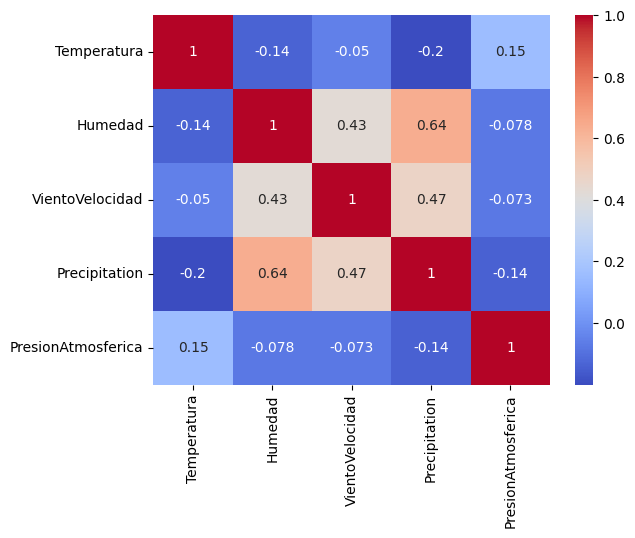

In [ ]:
matriz = x_train[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation','PresionAtmosferica']].corr()
sns.heatmap(matriz, annot=True, cmap='coolwarm')
plt.show()

Se observa que no hay ninguna correlación lineal fuerte entre las variables, por lo que no es conveniente seguir analizando relaciones lineales entre las variables, ya que no parece haber alguna que explique otra.

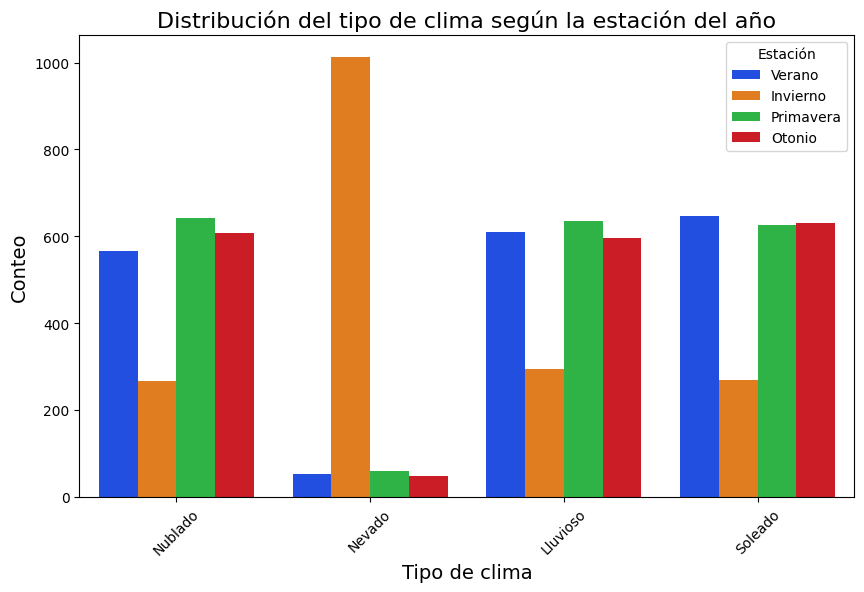

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_completo, x="TipoClima", hue="Estacion", palette="bright")

# Personalizar el gráfico
plt.title("Distribución del tipo de clima según la estación del año", fontsize=16)
plt.xlabel("Tipo de clima", fontsize=14)
plt.ylabel("Conteo", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Estación", loc="upper right")
plt.show()

Se observa que el tipo de clima nevado es el único que tiene una distribución no uniforme con base en las estaciones, teniendo muchos datos de invierno. Por lo que puede llegar a ser una variable importante para clasificar el invierno.

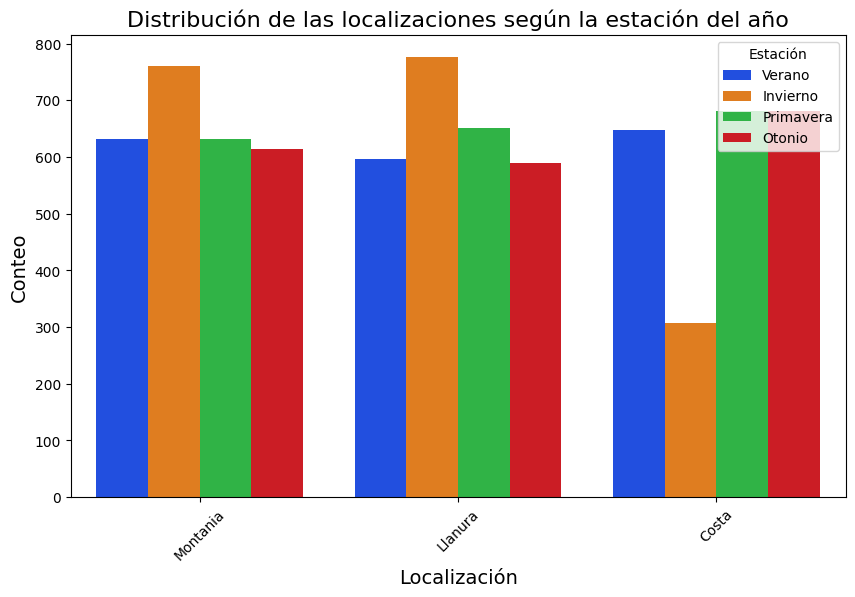

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_completo, x="Localizacion", hue="Estacion", palette="bright")

# Personalizar el gráfico
plt.title("Distribución de las localizaciones según la estación del año", fontsize=16)
plt.xlabel("Localización", fontsize=14)
plt.ylabel("Conteo", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Estación", loc="upper right")
plt.show()

Se observa que el único valor fuera de lo normal es la cantidad de datos de invierno en la costa y por tener menos datos en la costa, observamos más valores para las otras localizaciones en invierno; aun así, esto solamente ayuda a descartar el invierno en localizaciones de la costa. La mayoría de las localizaciones tiene casi la misma cantidad de datos para todas las estaciones, por lo que suponemos que ninguna localización va a ser de importancia para la clasificación de las estaciones.

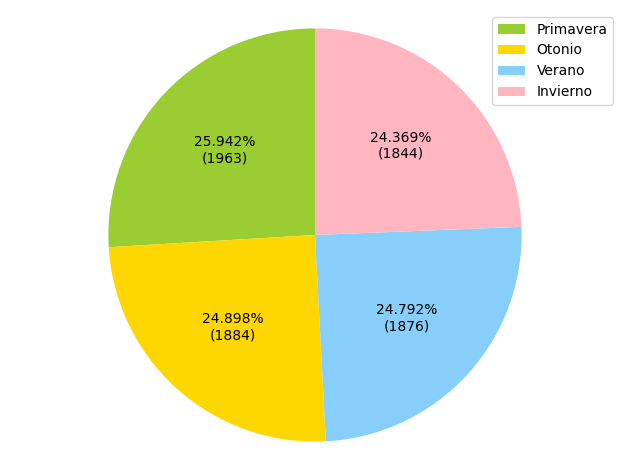

In [ ]:
temp = y_train.value_counts()
df_values = pd.DataFrame({'labels': temp.index, 'values': temp.values})

labels = df_values['labels']
sizes = df_values['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightpink']


def autopct_function(pct, all_values):
  total = sum(all_values)
  absolute = int(round(pct * total / 100))
  return f'{pct:.3f}%\n({absolute})'


patches, texts, autotexts = plt.pie(sizes,colors=colors, startangle=90, autopct=lambda pct: autopct_function(pct, sizes))
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

Observamos que el dataset está balanceado, por lo que no sería necesario hacer un balanceo del mismo. También podemos observar que un modelo con 25% de exactitud (accuracy) sería un modelo al azar, por lo que cualquier modelo que supere esta métrica estaría siendo mejor que clasificar al azar.

In [ ]:
x_train_codif = pd.get_dummies(x_train, columns=['TipoClima', 'Localizacion'], drop_first=True, dtype=float)
x_test_codif = pd.get_dummies(x_test, columns=['TipoClima', 'Localizacion'], drop_first=True, dtype=float)

Decidimos codificar las variables categoricas con OneHotEncoding, más en especifico la implementación de pandas.

In [ ]:
standar_scaler = StandardScaler(with_mean=False).set_output(transform='pandas')
x_train_codif[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation',
       'PresionAtmosferica']] = standar_scaler.fit_transform(x_train_codif[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation',
       'PresionAtmosferica']])
x_test_codif[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation',
       'PresionAtmosferica']] = standar_scaler.transform(x_test_codif[['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation',
       'PresionAtmosferica']])

Decidimos escalar las variables numéricas con un escalador normal o zscore.

In [ ]:
lab_enc = LabelEncoder()
y_train = pd.Series(lab_enc.fit_transform(y_train), name='target')
y_test = pd.Series(lab_enc.transform(y_test), name='target')

Decidimos codificar las estaciones para el entrenamiento de los modelos.

In [ ]:
y_train = y_train + 1
y_test = y_test + 1

Sumamos 1 a la codificación de la variable target para no comenzar con la clase 0.

In [ ]:
def calcular_metricas(y_pred, y_test):
    matrizvsm_lineal = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrizvsm_lineal, display_labels=sorted(y_test.unique()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.show()
    print("\n")
    print(classification_report(y_test,y_pred))
    return

En display_labels hacemos la función sorted de y_test.unique() para que los labels de la matriz de confusión concuerden con los labels codificados en el dataset.

In [ ]:
x_compl = pd.concat([x_train_codif, x_test_codif], ignore_index=True)
y_compl = pd.concat([y_train, y_test], ignore_index=True)

Juntamos todo el dataset en un dataframe para la validación cruzada

In [ ]:
def precision_per_class(y_true, y_pred, class_label):
    return precision_score(y_true, y_pred, labels=[class_label], average=None)[0]

def recall_per_class(y_true, y_pred, class_label):
    return recall_score(y_true, y_pred, labels=[class_label], average=None)[0]

classes = np.unique(y_compl)

scorers = {}
for cls in classes:
    scorers[f'precision_class_{cls}'] = make_scorer(precision_per_class, class_label=cls)
    scorers[f'recall_class_{cls}'] = make_scorer(recall_per_class, class_label=cls)

Creamos scorers que funcionen para CV, ya que cuando no se usa accuracy la validación cruzada de sklearn devuelve nan.

Las variables quedan codificadas de esta manera:



*   Invierno: 1

*   Otoño: 2

*   Verano: 3

*   Primavera: 4



---
---
---

## SVM Lineal

SVM por default

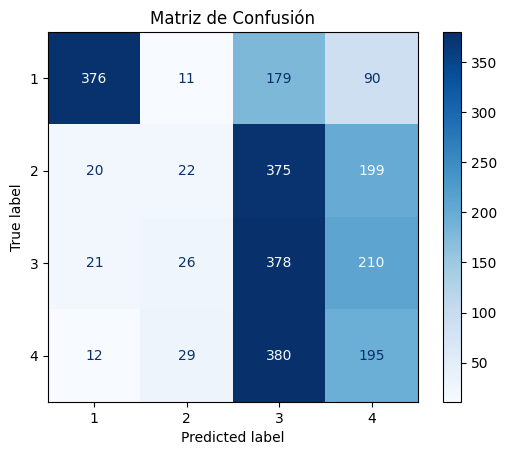



              precision    recall  f1-score   support

           1       0.88      0.57      0.69       656
           2       0.25      0.04      0.06       616
           3       0.29      0.60      0.39       635
           4       0.28      0.32      0.30       616

    accuracy                           0.38      2523
   macro avg       0.42      0.38      0.36      2523
weighted avg       0.43      0.38      0.37      2523



In [ ]:
svc_model_manual = SVC(kernel = 'linear', random_state=5232)
svc_model_manual.fit(x_train_codif, y_train)
y_pred_manual = svc_model_manual.predict(x_test_codif)
calcular_metricas(y_pred_manual, y_test)

Se observan unas métricas pobres, pero aun así es mejor que clasificar al azar. Por otro lado, vemos claramente que el invierno puede ser clasificado fácilmente y no es confundido con cualquier estación, mientras que las otras 3 estaciones, al tener distribuciones muy parecidas, es complicado diferenciarlas en un hiperplano superior. Nuestra hipótesis de este modelo es que el kernel lineal por default tiene un margen muy grande, que no es un hard margin, pero sigue siendo underfitteado.

SVM optimizado

In [ ]:
# svc_model = SVC(kernel = 'linear', random_state=5232)

# param_grid = {'C': [100,200,500,1000]}
# grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
# grid_search.fit(x_train_codif, y_train)

# print("Mejores hiperparámetros encontrados:")
# print(grid_search.best_params_)

In [ ]:
# best_svc_model = grid_search.best_estimator_
# y_pred = best_svc_model.predict(x_test_codif)

# calcular_metricas(y_pred, y_test)

Mejores hiperparámetros: {'C': 200}

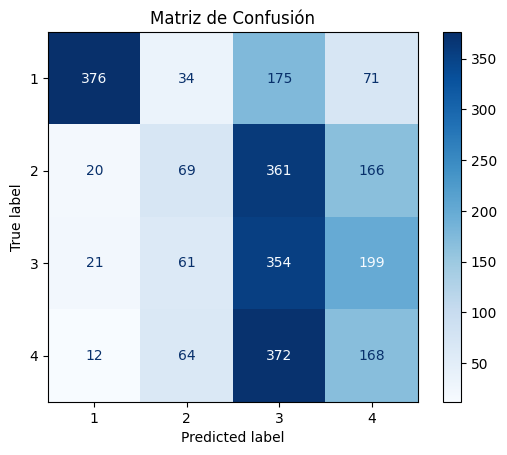



              precision    recall  f1-score   support

           1       0.88      0.57      0.69       656
           2       0.30      0.11      0.16       616
           3       0.28      0.56      0.37       635
           4       0.28      0.27      0.28       616

    accuracy                           0.38      2523
   macro avg       0.43      0.38      0.38      2523
weighted avg       0.44      0.38      0.38      2523



In [ ]:
svc_model_manual = SVC(kernel = 'linear', random_state=5232, C=200)
svc_model_manual.fit(x_train_codif, y_train)
y_pred_manual = svc_model_manual.predict(x_test_codif)
calcular_metricas(y_pred_manual, y_test)

Se observa que el modelo optimizado tiene un comportamiento parecido al modelo sin optimizar, siendo que predice un poco menos verano. Nuestra hipótesis es que el modelo de SVM lineal no puede crear un hiperplano superior a la dimensión del dataset que pueda diferenciar bien entre verano, otoño y primavera, terminando en un sesgo sobre verano. Además, observamos que, aunque se regularice, el hiperplano parece ser uno muy cercano, cambiando muy poco y siendo este el punto intermedio entre underfitting y overfitting aunque no sea muy notorio.

In [ ]:
results = cross_validate(
    svc_model_manual,
    x_compl,
    y_compl,
    cv=5,
    scoring=scorers,
    return_train_score=False
)

for cls in classes:
    precision_scores = results[f'test_precision_class_{cls}']
    recall_scores = results[f'test_recall_class_{cls}']
    print(f'Clase {cls}:')
    print(f'  Precisión (folds): {precision_scores}')
    print(f'  Promedio precisión: {precision_scores.mean()}')
    print(f'  Recall (folds): {recall_scores}')
    print(f'  Promedio recall: {recall_scores.mean()}')


Clase 1:
  Precisión (folds): [0.87009063 0.86138614 0.86138614 0.86607143 0.87272727]
  Promedio precisión: 0.8663323225935023
  Recall (folds): [0.576 0.522 0.522 0.582 0.576]
  Promedio recall: 0.5556
Clase 2:
  Precisión (folds): [0.28251121 0.28816467 0.28991597 0.27986348 0.33442623]
  Promedio precisión: 0.29497631068178165
  Recall (folds): [0.252 0.336 0.138 0.164 0.204]
  Promedio recall: 0.21880000000000002
Clase 3:
  Precisión (folds): [0.29861111 0.29460581 0.30171709 0.29812606 0.2952381 ]
  Promedio precisión: 0.29765963386777694
  Recall (folds): [0.57996146 0.54720617 0.70961538 0.67307692 0.53653846]
  Promedio recall: 0.6092796798577145
Clase 4:
  Precisión (folds): [0.26609442 0.33928571 0.27952756 0.26976744 0.29223744]
  Promedio precisión: 0.28938251574490603
  Recall (folds): [0.1242485  0.11422846 0.14257028 0.11646586 0.25702811]
  Promedio recall: 0.15090824218718563


Podemos observar que este modelo no presenta problemas con diferentes folds de testeo, ya sea por suerte de cómo se hicieron los folds o por poder predecir en general todas las clases. Nuestra hipótesis es que el SVM Lineal no tiene una varianza alta sobre las métricas en diferentes folds, porque aunque no sea el mejor modelo, puede predecir todas las clases. Además, observando clase por clase, las medias de las métricas por clase coinciden con la de la matriz de confusión (el reporte de clasificación).

In [ ]:
cv = 5

metricas_score = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
}

for nombre, metrica in metricas_score.items():
    scores = cross_val_score(svc_model_manual, x_compl, y_compl, cv=cv, scoring=metrica, verbose=1)
    print(f'Los 5 folds de {nombre} son: {scores}')
    print(f'La media de {nombre} es: {scores.mean()}')

Los 5 folds de accuracy son: [0.38503469 0.38156591 0.38156591 0.38701685 0.39494549]
La media de accuracy es: 0.3860257680872151
Los 5 folds de precision son: [0.42817701 0.44448929 0.43198645 0.42732269 0.44729178]
La media de precision es: 0.43585344486262567
Los 5 folds de recall son: [0.38503469 0.38156591 0.38156591 0.38701685 0.39494549]
La media de recall es: 0.3860257680872151


Aquí vemos cómo observamos anteriormente, las métricas en diferentes folds son equivalentes. Además, los promedios de los folds coinciden con las métricas calculadas en la matriz de confusión, en específico el reporte de clasificación.

---
---
---

## SVM Gaussiano

SVM Gaussiano por default

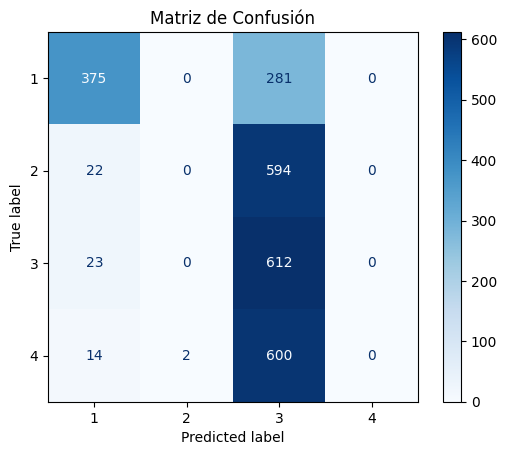



              precision    recall  f1-score   support

           1       0.86      0.57      0.69       656
           2       0.00      0.00      0.00       616
           3       0.29      0.96      0.45       635
           4       0.00      0.00      0.00       616

    accuracy                           0.39      2523
   macro avg       0.29      0.38      0.28      2523
weighted avg       0.30      0.39      0.29      2523



In [ ]:
svc_model_manual_rdf = SVC(kernel = 'rbf', random_state=5232)
svc_model_manual_rdf.fit(x_train_codif, y_train)
y_pred_manual = svc_model_manual_rdf.predict(x_test_codif)

calcular_metricas(y_pred_manual, y_test)

Observamos que sin modificar ningún parámetro se predicen solamente 2 clases y su accuracy es de 0.39. Aunque estos sean número "malos", hay que tener en cuenta que una accuracy random tendría que ser de 0.25 por tener 4 clases, entonces con ese dato en cuenta, 0.39 mejor que elegir al azar. Aun así que no pueda predecir 2 de las 4 clases, siendo que predice casi la misma cantidad de datos en invierno que el SVM lineal, con la diferencia de que el verano absorbe las otras 2 estaciones. Nuestra hipótesis de lo que ocurre con el kernel radial es que al tener un C default, el modelo funciona como un hard margin y esto hace que en el modelo este underfitteado, teniendo un margen excesivamente grande, el cual llega a un hiperplano que por tener el mínimo error dentro de los márgenes, termina clasificando 2 clases menos. También por la idea de que el kernel, al ser radial y tener un gamma el cual deja tener planos no lineales, estos se pueden underfittear y overfittear de manera más obvia.

SVM Gaussiano optimizado

In [ ]:
# svc_model = SVC(kernel = 'rbf', random_state=5232)

# param_grid = {'C': [100,200,500],
#               'gamma': [0.01,0.1]}
# grid_search_svc_radial = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=3)
# grid_search_svc_radial.fit(x_train_codif, y_train)

# print("Mejores hiperparámetros encontrados:")
# print(grid_search_svc_radial.best_params_)

Mejores hiperparámetros: {'C': 200, 'gamma': 0.1}

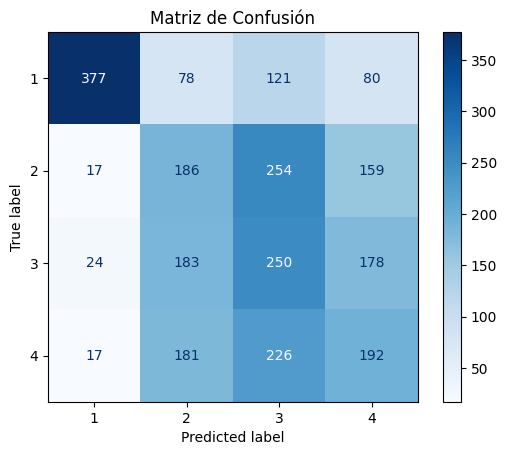



              precision    recall  f1-score   support

           1       0.87      0.57      0.69       656
           2       0.30      0.30      0.30       616
           3       0.29      0.39      0.34       635
           4       0.32      0.31      0.31       616

    accuracy                           0.40      2523
   macro avg       0.44      0.40      0.41      2523
weighted avg       0.45      0.40      0.41      2523



In [ ]:
svc_model_manual_rdf_opt = SVC(kernel = 'rbf',C=200,gamma=0.1, random_state=5232)
svc_model_manual_rdf_opt.fit(x_train_codif, y_train)
y_pred_manual_opt = svc_model_manual_rdf_opt.predict(x_test_codif)

calcular_metricas(y_pred_manual_opt, y_test)

Aquí observamos que una vez optimizado el kernel radial, la precisión y recall promedio son mejor, dándonos a entender que encontró un mejor margen y, por lo tanto, mejor hiperplano para diferenciar las clases. Esto gracias a C que, al ser muy pequeño, terminó siendo un hard margin y pasó a un soft margin según nuestra hipótesis.

Las variables quedan codificadas de esta manera:



*   Invierno: 1

*   Otoño: 2

*   Verano: 3

*   Primavera: 4



In [ ]:
results = cross_validate(
    svc_model_manual_rdf_opt,
    x_compl,
    y_compl,
    cv=5,
    scoring=scorers,
    return_train_score=False
)

for cls in classes:
    precision_scores = results[f'test_precision_class_{cls}']
    recall_scores = results[f'test_recall_class_{cls}']
    print(f'Clase {cls}:')
    print(f'  Precisión (folds): {precision_scores}')
    print(f'  Promedio precisión: {precision_scores.mean()}')
    print(f'  Recall (folds): {recall_scores}')
    print(f'  Promedio recall: {recall_scores.mean()}')


Clase 1:
  Precisión (folds): [0.85800604 0.84488449 0.84690554 0.88073394 0.84750733]
  Promedio precisión: 0.8556074689073256
  Recall (folds): [0.568 0.512 0.52  0.576 0.578]
  Promedio recall: 0.5508
Clase 2:
  Precisión (folds): [0.29811321 0.27689243 0.27628866 0.27615063 0.29230769]
  Promedio precisión: 0.2839505235085248
  Recall (folds): [0.316 0.278 0.268 0.264 0.304]
  Promedio recall: 0.28600000000000003
Clase 3:
  Precisión (folds): [0.31276901 0.2836767  0.3056338  0.30645161 0.29096478]
  Promedio precisión: 0.29989918147122185
  Recall (folds): [0.42003854 0.34489403 0.41730769 0.40192308 0.36538462]
  Promedio recall: 0.3899095894471617
Clase 4:
  Precisión (folds): [0.31304348 0.27147766 0.28488372 0.30696798 0.3015873 ]
  Promedio precisión: 0.29559202978854615
  Recall (folds): [0.28857715 0.31663327 0.29518072 0.32730924 0.30522088]
  Promedio recall: 0.3065842528430355


Observamos que en todas las clases y en todos los folds las métricas dan parecidas, lo que nos da a entender que es un modelo que puede generalizar mejor que sin optimizar. Por no tener picos en las métricas dependiendo el fold

In [ ]:
cv = 5

metricas_score = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
}

for nombre, metrica in metricas_score.items():
    scores = cross_val_score(svc_model_manual_rdf_opt, x_compl, y_compl, cv=cv, scoring=metrica, verbose=1)
    print(f'Los 5 folds de {nombre} son: {scores}')
    print(f'La media de {nombre} es: {scores.mean()}')

Los 5 folds de accuracy son: [0.39841427 0.36273538 0.37561943 0.39246779 0.38800793]
La media de accuracy es: 0.3834489593657086
Los 5 folds de precision son: [0.44429903 0.41802974 0.42735321 0.44136134 0.43181351]
La media de precision es: 0.43257136595303136
Los 5 folds de recall son: [0.39841427 0.36273538 0.37561943 0.39246779 0.38800793]
La media de recall es: 0.3834489593657086


Se puede observar que, como se destacó en las métricas por clase, el modelo puede generalizarse sobre todos los folds sin tener picos en las métricas por falta de alguna de las clases. Nuestra hipótesis es que nuestro modelo se encuentra en un punto intermedio entre underfitting y overfitting, es decir, well fitting.

---
---
---

## RandomForestClassifier

Random Forest por default

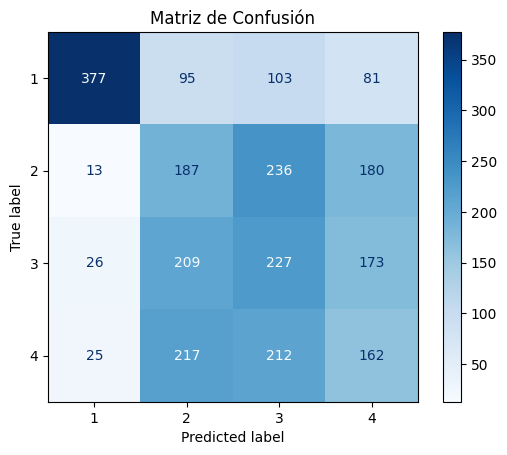



              precision    recall  f1-score   support

           1       0.85      0.57      0.69       656
           2       0.26      0.30      0.28       616
           3       0.29      0.36      0.32       635
           4       0.27      0.26      0.27       616

    accuracy                           0.38      2523
   macro avg       0.42      0.37      0.39      2523
weighted avg       0.43      0.38      0.39      2523



In [ ]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(x_train_codif, y_train)
y_pred_default = rf_default.predict(x_test_codif)

calcular_metricas(y_pred_default, y_test)

Se observa que cuando el random forest no es optimizado sucede lo mismo que en todos los modelos que el invierno es fácilmente diferenciable, pero en general parece tener una métrica decentes, en comparación con los otros modelos defaults, no parece estar underfitteado, ya que predice todas las clases. Nuestra hipótesis es que el modelo por default del random forest tiene unas métricas que funcionan más o menos bien para el dataset que tenemos.

Random Forest optimizado

In [ ]:
# rf_classifier = RandomForestClassifier(random_state=42)

# param_grid = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

# grid_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')

# grid_search.fit(x_train_codif, y_train)

# best_params = grid_search.best_params_
# print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'max_depth': 4, 'n_estimators': 199}

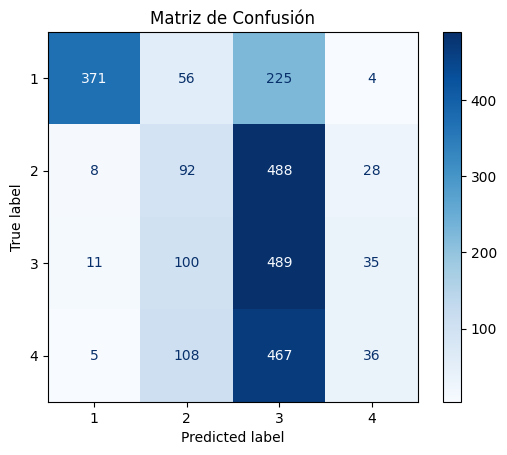



              precision    recall  f1-score   support

           1       0.94      0.57      0.71       656
           2       0.26      0.15      0.19       616
           3       0.29      0.77      0.42       635
           4       0.35      0.06      0.10       616

    accuracy                           0.39      2523
   macro avg       0.46      0.39      0.35      2523
weighted avg       0.47      0.39      0.36      2523



In [ ]:
best_rf_classifier = RandomForestClassifier(max_depth=4, n_estimators=190,random_state=42)
best_rf_classifier.fit(x_train_codif, y_train)
y_pred_GS = best_rf_classifier.predict(x_test_codif)

calcular_metricas(y_pred_GS, y_test)

Podemos observar que, en comparación al random forest sin optimizar, se ve un recorte grande en la predicción de las clases otoño y primavera, pero las métricas promedio son mejores. Nuestra hipótesis es que al optimizar y tener una máxima profundidad de 4, que a diferencia el modelo default que es sin límite, en árboles más cortos, es más complicado que se pueda llegar a diferenciar las clases que tienen una distribución parecida, y termina dominando verano por una pequeña diferencia de probabilidad y el voto mayoritario.

In [ ]:
results = cross_validate(
    best_rf_classifier,
    x_compl,
    y_compl,
    cv=5,
    scoring=scorers,
    return_train_score=False
)

for cls in classes:
    precision_scores = results[f'test_precision_class_{cls}']
    recall_scores = results[f'test_recall_class_{cls}']
    print(f'Clase {cls}:')
    print(f'  Precisión (folds): {precision_scores}')
    print(f'  Promedio precisión: {precision_scores.mean()}')
    print(f'  Recall (folds): {recall_scores}')
    print(f'  Promedio recall: {recall_scores.mean()}')


Clase 1:
  Precisión (folds): [0.95302013 0.95202952 0.9588015  0.94333333 0.92508143]
  Promedio precisión: 0.9464531838417642
  Recall (folds): [0.568 0.516 0.512 0.566 0.568]
  Promedio recall: 0.546
Clase 2:
  Precisión (folds): [0.25675676 0.30718954 0.22580645 0.24117647 0.22608696]
  Promedio precisión: 0.2514032355926589
  Recall (folds): [0.076 0.094 0.126 0.082 0.104]
  Promedio recall: 0.0964
Clase 3:
  Precisión (folds): [0.29255319 0.29582712 0.30689929 0.27979275 0.30087848]
  Promedio precisión: 0.295190164977212
  Recall (folds): [0.74181118 0.76493256 0.74423077 0.62307692 0.79038462]
  Promedio recall: 0.7328872091299836
Clase 4:
  Precisión (folds): [0.28125    0.31746032 0.31279621 0.23846154 0.36521739]
  Promedio precisión: 0.30303709115140187
  Recall (folds): [0.14428858 0.16032064 0.13253012 0.18674699 0.08433735]
  Promedio recall: 0.1416447352536398


Aquí podemos observar que el modelo no tiene problemas en los diferentes folds, dándonos a entender que no está ni overfitteado ni underfitteado.

In [ ]:
cv = 5

metricas_score = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
}

for nombre, metrica in metricas_score.items():
    scores = cross_val_score(best_rf_classifier, x_compl, y_compl, cv=cv, scoring=metrica, verbose=1)
    print(f'Los 5 folds de {nombre} son: {scores}')
    print(f'La media de {nombre} es: {scores.mean()}')

Los 5 folds de accuracy son: [0.38602577 0.38751239 0.38255699 0.36719524 0.39098117]
La media de accuracy es: 0.3828543111992071
Los 5 folds de precision son: [0.44453286 0.46657904 0.449784   0.42443061 0.45288368]
La media de precision es: 0.4476420381066476
Los 5 folds de recall son: [0.38602577 0.38751239 0.38255699 0.36719524 0.39098117]
La media de recall es: 0.3828543111992071


Podemos observar que en las medias de las métricas tampoco tiene problemas sobre los diferentes folds ya sea por suerte o como nosotros pensamos, que es por ser un punto well fitting.

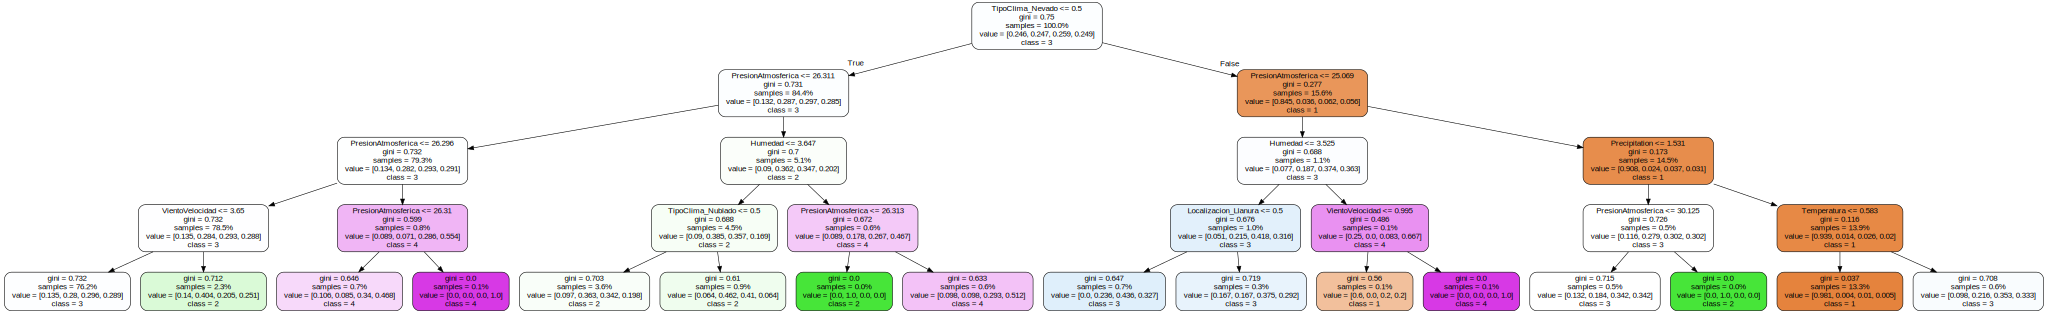

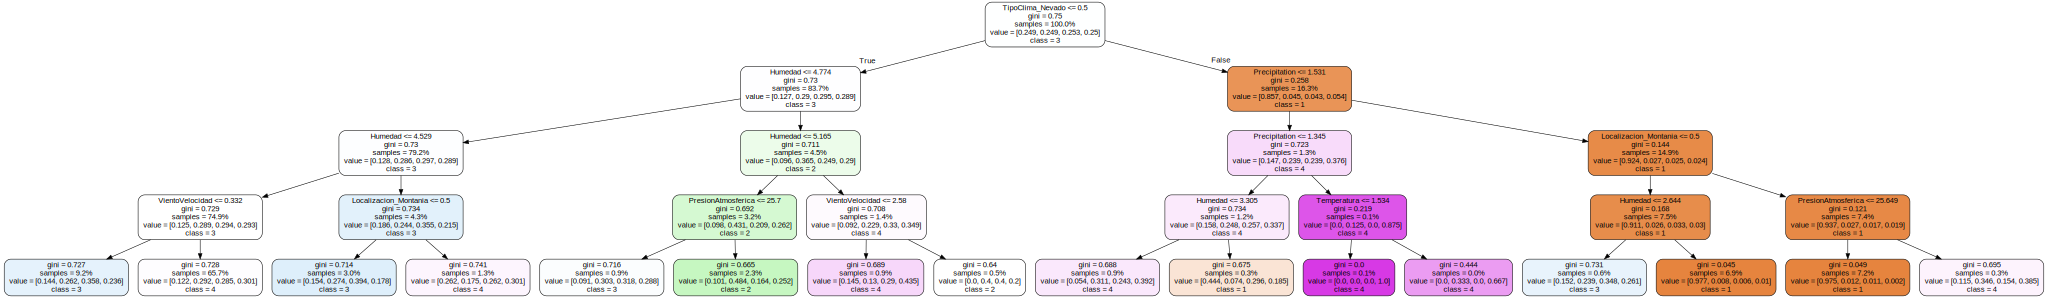

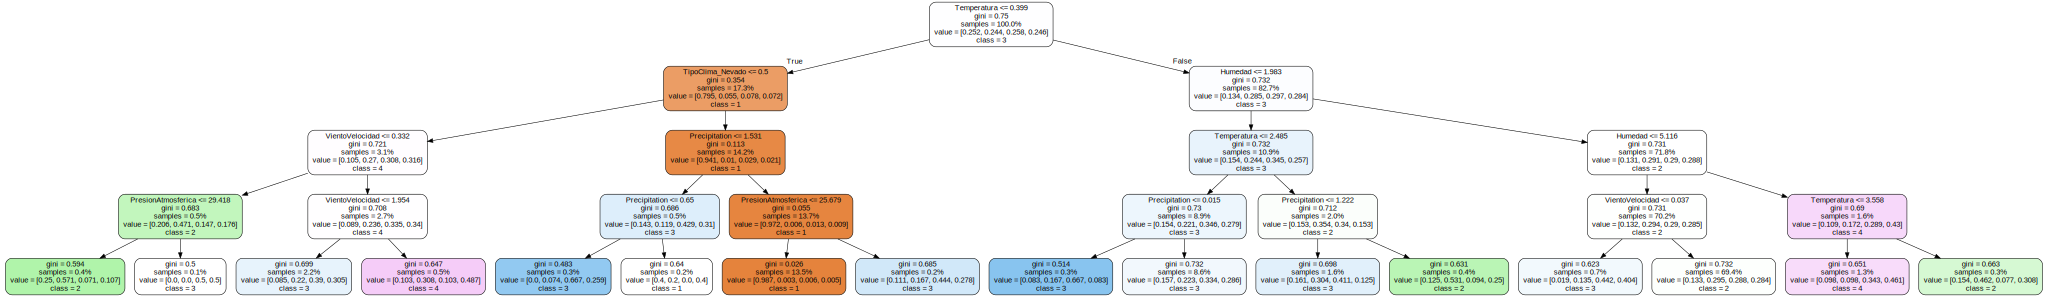

In [ ]:
for i in range(1,4):
    tree = best_rf_classifier.estimators_[i]
    dot_data = export_graphviz(tree, feature_names=x_train_codif.columns, class_names=[str(c) for c in best_rf_classifier.classes_], filled=True, rounded=True, max_depth=4, proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Podemos observar que en los datos de testeo, parece haber 600 datos de cada clase, y al ser cada clase un 25% del dataset, vemos en los árboles que siempre hay un 14/13% de los datos que son clasificados como invierno, con mucha probabilidad de ser invierno. Esto se ve reflejado en la matriz de confusión, ya que la mitad del 25% es el 12.5% y al ser más o menos 600 datos por clase, termina clasificando mínimo 300 datos para invierno y los predice bien. Después observamos que pocos datos obtienen probabilidades altas de ser primavera u otoño y la gran mayoría de los datos se desemboca en verano por tener un poco más de probabilidades. También se puede observar que justo los árboles seleccionados tienen una predicción diferentes de las clases, siendo que todos predicen invierno, pero su resto de predicciones va uno a primavera, otro verano y otro otoño, lo que no es exactamente lo que refleja la matriz de confusión, pero nuestra hipótesis es obviamente porque estamos observando 3 árboles de 190.

---
---
---

## Conclusiones

En este trabajo pudimos observar que aun teniendo un dataset balanceado, los modelos tienen problemas a la hora de generalizar, esto porque hay diferentes características de los datasets que pueden llegar a complicar la clasificación, así como la poca diferencia entre las distribuciones de las variables seleccionadas para el problema, como la cantidad de variables, la cantidad de datos, etc. También en este trabajo aprendimos que la validación cruzada utilizando todos los datos, nos da una idea de si el modelo está poco entrenado, bien entrenado o sobre entrenado, ya que dependiendo de la variabilidad de las métricas en el fold uno puede ver esto. Aún más, uno obtiene las métricas por cada clase (en el caso de precisión y exhaustividad)